# Proyecto Statistical Learning I

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from scipy import stats


#habilitamos compatibilidad para TensorFlow v1
if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()

In [3]:
titanic_dataset = pd.read_csv('data_titanic_proyecto.csv')

train_data, test_data = train_test_split(titanic_dataset, test_size=0.2)
train_data, validation_data = train_test_split(train_data, test_size=0.2)

train_data

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived
625,626,"Sutton, Mr. Frederick",61.0,0,0,36963,32.3208,D50,S,Upper,M,N
52,53,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",49.0,1,0,PC 17572,76.7292,D33,C,Upper,F,Y
845,846,"Abbing, Mr. Anthony",42.0,0,0,C.A. 5547,7.5500,NaN,S,Lower,M,N
693,694,"Saad, Mr. Khalil",25.0,0,0,2672,7.2250,NaN,C,Lower,M,N
570,571,"Harris, Mr. George",62.0,0,0,S.W./PP 752,10.5000,NaN,S,Middle,M,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
811,812,"Lester, Mr. James",39.0,0,0,A/4 48871,24.1500,NaN,S,Lower,M,N
307,308,"Penasco y Castellana, Mrs. Victor de Satode (M...",17.0,1,0,PC 17758,108.9000,C65,C,Upper,F,Y
361,362,"del Carlo, Mr. Sebastiano",29.0,1,0,SC/PARIS 2167,27.7208,NaN,C,Middle,M,N
202,203,"Johanson, Mr. Jakob Alfred",34.0,0,0,3101264,6.4958,NaN,S,Lower,M,N


### Análisis exploratorio de datos

In [4]:
train_data.isna().sum()

PassengerId             0
Name                    0
Age                   114
SibSp                   0
Parch                   0
Ticket                  0
Fare                    0
Cabin                 439
Embarked                2
passenger_class         0
passenger_sex           0
passenger_survived      0
dtype: int64

In [5]:
for column in train_data.drop(['Cabin'],axis=1):
    print(column+" : "+str(train_data[column].dropna().unique().shape[0]))

PassengerId : 569
Name : 569
Age : 77
SibSp : 7
Parch : 6
Ticket : 473
Fare : 213
Embarked : 3
passenger_class : 3
passenger_sex : 2
passenger_survived : 2


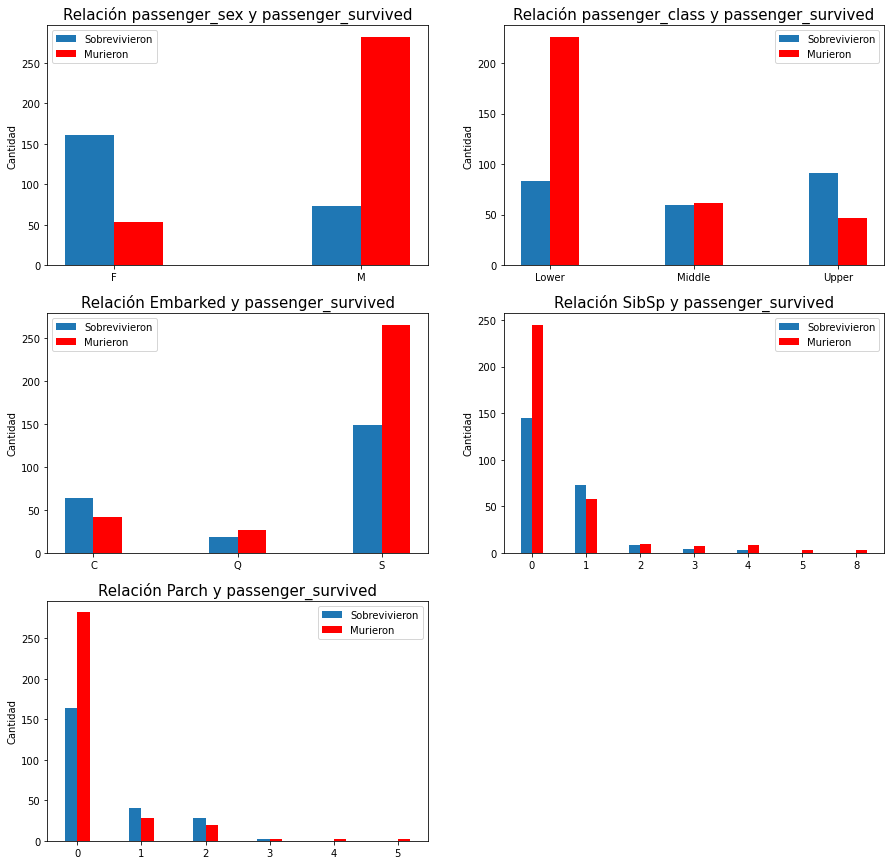

In [6]:
f,axes = plt.subplots(3,2,sharex=False, figsize=(15,15))
i_vars = ["passenger_sex","passenger_class","Embarked","SibSp","Parch"]

for i in range(len(i_vars)):
    ivar = i_vars[i]
    labels = sorted(train_data[ivar].dropna().unique())
    survivors = []
    deaths = []
    for label in labels:
        survivors.append(train_data[(train_data[ivar] == label) & (train_data["passenger_survived"] == "Y")][ivar].count())
        deaths.append(train_data[(train_data[ivar] == label) & (train_data["passenger_survived"] == "N")][ivar].count())
        
    width = 0.20
    x_plt = np.arange(len(labels))
    
    ax = axes[i//2,i%2]
    rects1 = ax.bar(x_plt, survivors, width, label='Sobrevivieron')
    rects2 = ax.bar(x_plt + width, deaths, width, label='Murieron',color="red")

    ax.set_ylabel('Cantidad')
    ax.set_title('Relación '+ivar+' y passenger_survived', fontsize=15)
    ax.set_xticks(x_plt+width/2)
    ax.set_xticklabels(labels)
    ax.legend()
    
f.delaxes(axes[2,1])
plt.show()

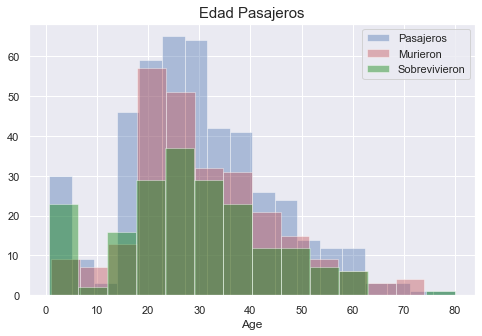

In [7]:
sns.set();
plt.figure(figsize=(8,5))
sns.distplot(train_data["Age"].dropna(), kde=False, label="Pasajeros")
sns.distplot(train_data[(train_data["passenger_survived"] == "N")]["Age"].dropna(),color="r", kde =False, label="Murieron")
sns.distplot(train_data[(train_data["passenger_survived"] == "Y")]["Age"].dropna(), color="green", kde =False, label="Sobrevivieron")
plt.title("Edad Pasajeros",fontsize=15)
plt.legend()
plt.show()

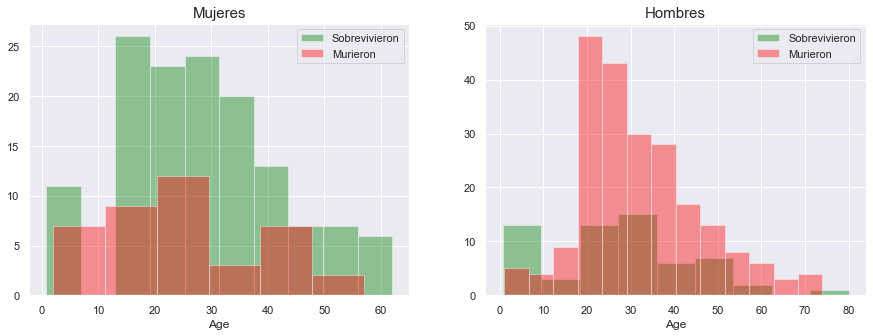

In [8]:
sns.set();

f,axes = plt.subplots(1,2,sharex=False, figsize=(15,5))

sns.distplot(train_data[(train_data["passenger_sex"] == "F") & (train_data["passenger_survived"] == "Y")]["Age"].dropna(), color="green", kde=False, ax=axes[0],label="Sobrevivieron")
sns.distplot(train_data[(train_data["passenger_sex"] == "F") & (train_data["passenger_survived"] == "N")]["Age"].dropna(), color="red", kde=False, ax=axes[0],label="Murieron")
sns.distplot(train_data[(train_data["passenger_sex"] == "M") & (train_data["passenger_survived"] == "Y")]["Age"].dropna(), color="green", kde=False,ax=axes[1], label="Sobrevivieron")
sns.distplot(train_data[(train_data["passenger_sex"] == "M") & (train_data["passenger_survived"] == "N")]["Age"].dropna(), color="red", kde=False, ax=axes[1],label="Murieron")
axes[0].legend()
axes[0].set_title("Mujeres",fontsize=15)
axes[1].legend()
axes[1].set_title("Hombres",fontsize=15)
plt.show()

### Selección de variables y feature engineering
Según el análisis realizado se seleccionó como variables independientes **passenger_sex** y **passenger_class** por lo que se procederá a realizar un mapeo númerico de categorías a estas variables y a la variable **passenger_survived** la cuál contiene la clasificación de sobrevivencia.

Estás variables codificadas se agregarán como una nueva columna en el dataset de pruebas.

In [28]:
train_data["sex_encoded"] = train_data["passenger_sex"].map({'M': 0, 'F': 1}).astype(int)
train_data["class_encoded"] = train_data["passenger_class"].map( {'Lower': 0, 'Middle': 1,'Upper':2}).astype(int)
train_data["survived_encoded"] = train_data["passenger_survived"].map({'N': 0, 'Y': 1}).astype(int)
train_data["age_t"] = train_data["Age"].fillna(train_data["Age"].mean()).astype(int)

train_data.head(5)

,PassengerId,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,passenger_class,passenger_sex,passenger_survived,sex_encoded,class_encoded,survived_encoded,age_t,sibp_t,parch_t,embarked_t
625,626,"Sutton, Mr. Frederick",61.0,0,0,36963,32.3208,D50,S,Upper,M,N,0,2,0,61,0,0,S
52,53,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",49.0,1,0,PC 17572,76.7292,D33,C,Upper,F,Y,1,2,1,49,1,0,C
845,846,"Abbing, Mr. Anthony",42.0,0,0,C.A. 5547,7.5500,NaN,S,Lower,M,N,0,0,0,42,0,0,S
693,694,"Saad, Mr. Khalil",25.0,0,0,2672,7.2250,NaN,C,Lower,M,N,0,0,0,25,0,0,C
570,571,"Harris, Mr. George",62.0,0,0,S.W./PP 752,10.5000,NaN,S,Middle,M,Y,0,1,1,62,0,0,S


,PassengerId,Age,SibSp,Parch,Fare,sex_encoded,class_encoded,survived_encoded,age_t,sibp_t,parch_t
0,-0.055679,-0.079801,-0.013194,0.111632,0.264985,0.538198,0.335493,1.0,-0.070087,-0.013194,0.111632


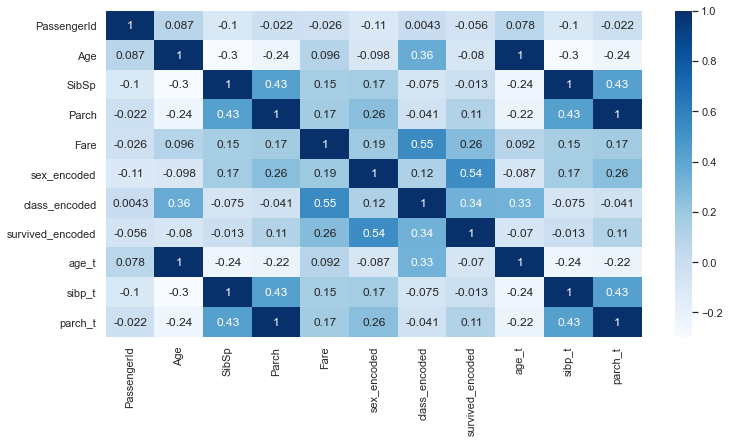

In [10]:
corr = train_data.corrwith(train_data["survived_encoded"])

plt.figure(figsize=(12,6))
sns.heatmap(train_data.corr(), cmap="Blues", annot=True)

corr.to_frame().T

Como se puede validar en el mapa de calor, sexo y clase son las variables que representan una correlación más alta entre las demás variables, por lo que se seleccionaran dichas variables para realizar entrenar los modelos de predicción.

## Modelos de Clasificación

### Definición de Clasificador Naive Bayes

Se define la clase **NaiveBayesClassifier** para poder realizar predicciones por medio de un clasificador binario Naive Bayes. Este recibe como entrada en su constructor un arreglo con variables independientes y la variable a predecir (clases).

El método **predict** recibe como entrada un arreglo con las variables independientes y retorna como resultado un arreglo con las predicciones realizadas.

In [11]:
class NaiveBayesClassifier:
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.df = pd.DataFrame(np.hstack((x,y.reshape(-1,1))))
        self.df.columns = [*self.df.columns[:-1], 'Y']
        self.means = self.df.groupby('Y').mean()
        self.stds = self.df.groupby('Y').std()
        self.class_prob = self.df.groupby('Y')['Y'].count() / self.df.shape[0]
    
    def predict(self,x):
        predictions = np.zeros((len(self.df['Y'].unique()),x.shape[0]))
        for c in self.df['Y'].unique():
            mean = self.means.loc[c].to_numpy()
            std = self.stds.loc[c].to_numpy() 
            vars_prob = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-((x-mean)**2 / (2 * std**2 )))
            probablilites = self.class_prob[c]*np.product(vars_prob,axis=1)
            predictions[c] = probablilites

        return np.argmax(predictions.T,axis=1)

### Definición de Modelo de Regresión Logistica

Se implementa la clase **LogisticRegressionModel** la cual cuenta con 2 métodos, el método **train** el cuál recibe como entrada las variables independientes, las clasificaciones y los hiperpárametros como epochs, learning rate, batch_size, etc.

Una vez entrenado el modelo, los pesos calculados durante este proceso son almacenados en el campo **weights** y son utilizados por el método **predict** para realizar clasificaciones sobre el parametro brindado a este método.

In [12]:
class LogisticRegressionModel:
    def __init__(self):
        self.weights = None
        
    def train(self,x, y , epochs, lr, batch_size, beta, print_interval,logs_dir):
        x = np.hstack((x,np.ones((x.shape[0],1))))
        y = y.reshape(-1,1)
        tf.reset_default_graph()

        total_iterations = int(x.shape[0]/batch_size)

        with tf.name_scope("Pesos"):
            x_train = tf.placeholder(tf.float32,[batch_size,x.shape[1]],"X")
            train_labels = tf.placeholder(tf.float32,[batch_size,y.shape[1]],"Train_Labels")
            weights = tf.Variable(name="Weights", initial_value=tf.zeros(([x.shape[1],y.shape[1]]),dtype=tf.float32))
        with tf.name_scope("Calcular_Logits"):
            logits = tf.matmul(x_train,weights)
        with tf.name_scope("Regularizacion"):
            regularizer =  tf.math.reduce_sum(tf.square(weights[:-1])) / 2
        with tf.name_scope("Calcular_Costo"):
            sigmoid_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits,labels=train_labels)
            loss = tf.reduce_mean(sigmoid_entropy + beta * regularizer)
        with tf.name_scope("Calcular_Gradientes"):
            gradients = tf.gradients(loss ,weights)
        with tf.name_scope("Actualizar_Pesos"):
            update_weights = tf.assign(weights,(tf.add(weights,tf.scalar_mul(-lr,gradients[0]))))

        loss_summary = tf.summary.scalar(name='Loss_vs_Epochs', tensor=loss)

        with tf.Session() as session:
            curr_datetime = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
            #writer = tf.summary.FileWriter(logs_dir+curr_datetime+"_lr="+str(lr)+"_epochs="+str(epochs),session.graph)
            session.run(tf.global_variables_initializer())
            x_mb = None
            y_mb = None
            for epoch in range(epochs):
                for i in range(total_iterations):
                    batch_start  = i*batch_size
                    batch_end = batch_start + batch_size

                    x_mb = np.array(x[batch_start:batch_end])
                    y_mb = np.array(y[batch_start:batch_end])

                    session.run(update_weights, feed_dict={x_train: x_mb, train_labels: y_mb})

                if ((epoch+1) % print_interval) == 0:
                    print("epoch:"+str(epoch+1)+" costo: "+str(session.run(loss, feed_dict={x_train: x_mb, train_labels: y_mb})))

                #writer.add_summary(session.run(loss_summary, feed_dict={x_train: x_mb, train_labels: y_mb}), epoch)


            self.weights = session.run(weights)
            #writer.close()
        session.close()

        return self.weights

    def predict(self,x):
        x = np.hstack((x,np.ones((x.shape[0],1))))
        tf.reset_default_graph()
        x_ph = tf.placeholder(tf.float32,[x.shape[0],None],"Predicted_Image")
        with tf.Session() as session:
            prediction = session.run(tf.cast(tf.nn.sigmoid(tf.matmul(x_ph,self.weights)) > 0.5, tf.int32),feed_dict={x_ph: x})
        session.close()
        return prediction.reshape(prediction.shape[0])

### SVM y Decision Trees

Para los clasificadores SVM y Decision Trees, se utilizarán librerías de skilearn, por lo que se procede a importar dichas librerías y posteriormente se creará una instancia para cada uno de los clasificadores. 

In [13]:
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier

## Entrenamiento y validación de clasificadores
Se procede a crear una instancia de cada uno de los clasificadores y se entrenan con los datos de pruebas a los cuales se les realizaron encoding.

In [29]:
#se agregan las columnas encodeadas a los datos de validación
validation_data["sex_encoded"] = validation_data["passenger_sex"].map({'M': 0, 'F': 1}).astype(int)
validation_data["class_encoded"] = validation_data["passenger_class"].map( {'Lower': 0, 'Middle': 1,'Upper':2}).astype(int)
validation_data["survived_encoded"] = validation_data["passenger_survived"].map({'N': 0, 'Y': 1}).astype(int)
validation_data["age_t"] = validation_data["Age"].fillna(validation_data["Age"].mean()).astype(int)

x_train = train_data[["sex_encoded","class_encoded"]].to_numpy()
y_train = train_data["survived_encoded"].to_numpy()

x_validation = validation_data[["sex_encoded","class_encoded"]].to_numpy()
y_validation = validation_data["survived_encoded"].to_numpy()

naive_bayes_clf = NaiveBayesClassifier(x_train,y_train)
logistic_regression_clf = LogisticRegressionModel()
svm_clf = svm.SVC(kernel='linear') 
decision_tree_clf = DecisionTreeClassifier(criterion='entropy')

accurrancy = {}

### Naive Bayes

In [23]:
y_pred_nb  = naive_bayes_clf.predict(x_validation)
accurrancy['Naive Bayes'] = metrics.accuracy_score(y_validation, y_pred_nb)
print("Naive Bayes Accuracy:", accurrancy['Naive Bayes'])

Naive Bayes Accuracy: 0.8041958041958042


In [24]:
svm_clf.fit(x_train,y_train)
y_pred_svm  = svm_clf.predict(x_validation)
accurrancy['SVM'] = metrics.accuracy_score(y_validation, y_pred_svm)
print("Accuracy:",accurrancy['SVM'])

Accuracy: 0.8041958041958042


In [25]:
decision_tree_clf.fit(x_train,y_train)
y_pred_dt  = decision_tree_clf.predict(x_validation)
accurrancy['Decission Trees'] = metrics.accuracy_score(y_validation, y_pred_dt)
print("Accuracy:",accurrancy['Decission Trees'] )

Accuracy: 0.8041958041958042


In [26]:
logistic_regression_clf.train(x=x_train,y=y_train,epochs=1000, lr=0.001, batch_size=32, beta=0.01, print_interval=200,  logs_dir="./fashion_mnist/")
y_pred_lr = logistic_regression_clf.predict(x_validation)
accurrancy['Regresión Logistica']  = metrics.accuracy_score(y_validation, y_pred_lr)
print("Accuracy:",accurrancy['Regresión Logistica'])

epoch:200 costo: 0.6375417
epoch:400 costo: 0.60360456
epoch:600 costo: 0.58124846
epoch:800 costo: 0.5659263
epoch:1000 costo: 0.5551665
Accuracy: 0.7762237762237763


### Ensamble de calificadores

In [19]:
def ensemble_classifier(predictions):
    return stats.mode(predictions, axis=0)[0][0]

In [27]:
predictions = np.array((y_pred_nb,y_pred_svm,y_pred_dt,y_pred_lr))
y_pred_ensemble = ensemble_classifier(predictions)
accurrancy['Ensamble'] = metrics.accuracy_score(y_validation, y_pred_ensemble)
print("Accuracy:",accurrancy['Ensamble'])

Accuracy: 0.8041958041958042


In [21]:
df_accuracy = pd.DataFrame(accurrancy, index={"Precisión"})

df_accuracy.T

,Precisión
Naive Bayes,0.790210
SVM,0.804196
Decission Trees,0.853147
Regresión Logistica,0.825175
Ensamble,0.839161
